# Unemployment Analysis

- Your analysis here
  
---

In [71]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [72]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [73]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [74]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [75]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [76]:
from scipy import stats

In [77]:
from statsmodels.stats.diagnostic import het_breuschpagan

In [78]:
from scipy.stats import shapiro

In [79]:
import seaborn as sns
import statsmodels.api as sm

In [80]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import os





In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
import numpy as np

In [83]:
import statsmodels.formula.api as smf

In [84]:
#find current directory
current_dir = os.getcwd()
print(current_dir)

/Users/davidhenderson/Desktop/UCB-data-project-1-groupx


In [85]:
#load yearly education data
education_to_load =os.path.join(current_dir, "Data", "Education attainment.csv")
education_data=pd.read_csv(education_to_load)


In [86]:
#create month column for each year in education data
value_count = education_data['year'].count()
months_data = {
    'Month': [str(month).zfill(2) for month in range(1, 13)] * value_count   # Repeat months for each year
}
months_df = pd.DataFrame(months_data)
monthly_edu = pd.concat([education_data]*12, ignore_index = True)
monthly_edu = monthly_edu.sort_values(by=['year'])
monthly_edu = monthly_edu.reset_index(drop=True)
monthly_edu_data = pd.concat([monthly_edu, months_df], axis=1)
#drop NA data
monthly_edu_data= monthly_edu_data.dropna()
# convert year data type to integer
monthly_edu_data['year'] = monthly_edu_data['year'].astype(int)

#create year-month column
monthly_edu_data['YearMonth'] = pd.to_datetime(monthly_edu_data['year'].astype(str) + '-' + monthly_edu_data['Month'].astype(str) + '-01')
#Clean up Education Data
monthly_edu_data=monthly_edu_data[['YearMonth','% Highest degree is middle school', '% Highest degree is High School', '% Highest degree is  College (4 + years)']]
#convert degree % columns type from object to float
monthly_edu_data['% Highest degree is middle school']=monthly_edu_data['% Highest degree is middle school'].str.rstrip('%').astype(float) / 100
monthly_edu_data['% Highest degree is High School']=monthly_edu_data['% Highest degree is High School'].str.rstrip('%').astype(float) / 100
monthly_edu_data['% Highest degree is  College (4 + years)']=monthly_edu_data['% Highest degree is  College (4 + years)'].str.rstrip('%').astype(float) / 100
nan_counts = monthly_edu_data.isna().sum()


In [87]:
#exam unemployment data
unemployment_to_load = os.path.join(current_dir , "Data", "MonthlyUnemployment.csv")
unemployment_data = pd.read_csv(unemployment_to_load)

In [88]:
#transform unemployment data
unemployment_df = unemployment_data.melt(id_vars=['Year'], var_name='Month', value_name='Unemployment Rate')

month_map = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
    # Add more months as needed
}
unemployment_df['MonthNum'] = unemployment_df['Month'].map(month_map)
unemployment_df['YearMonth'] = unemployment_df['Year'].astype(str) + '-' + unemployment_df['MonthNum'] + '-01'
unemployment_df['YearMonth'] = unemployment_df['Year'].astype(str) + '-' + unemployment_df['MonthNum'] + '-01' 
unemployment_df = unemployment_df[['YearMonth', 'Unemployment Rate' ]]
unemployment_df['YearMonth'] = pd.to_datetime(unemployment_df['YearMonth'])


In [89]:
#exam men unemployment data
men_unemploy_to_load = os.path.join(current_dir, "Data", "Men_Unemployment.csv")
unemployment_men = pd.read_csv(men_unemploy_to_load)
unemployment_men ['YearMonth'] = pd.to_datetime(unemployment_men ['DATE'])

In [90]:
#exam women unemployment data
women_unemploy_to_load = os.path.join(current_dir, "Data", "Women_Unemployment.csv")
unemployment_women = pd.read_csv(women_unemploy_to_load )
unemployment_women ['YearMonth'] = pd.to_datetime(unemployment_women ['DATE'])

In [91]:
#load and exam gdp data
gdp_to_load = os.path.join(current_dir, "Data", "MonthlyGDP.csv")
gdp_data = pd.read_csv(gdp_to_load)
# Define a function to correctly parse two-digit years
def parse_date(date_str):
    # Use pd.to_datetime with dayfirst=False for m/d/y format
    date = pd.to_datetime(date_str, format='%m/%d/%y', errors='coerce')
    # Fix the century if necessary
    if date.year > pd.Timestamp.now().year:
        date = date.replace(year=date.year - 100)
    return date

# Create a YearMonth column
gdp_data['YearMonth'] = gdp_data['DATE'].apply(parse_date)
gdp_data['YearMonth'] = gdp_data['YearMonth'].dt.strftime('%Y-%m-%d')
gdp_data = gdp_data[['YearMonth','USALORSGPNOSTSAM']]
gdp_data['YearMonth'] = pd.to_datetime(gdp_data['YearMonth'])

#Prepare data to calc gdp growth
gdp_data['USALORSGPNOSTSAM1']= gdp_data['USALORSGPNOSTSAM'].shift(-1)

In [92]:
#load and explore laborforce_data
laborforce_to_load = os.path.join(current_dir, "Data", "Labor force participation rate_monthly.csv")
laborforce_data = pd.read_csv(laborforce_to_load)
#change laborforce column name
laborforce_data.rename(columns={'observation_date': 'YearMonth', 'CIVPART': 'Labor Force Participation'}, inplace=True)
laborforce_data['YearMonth'] = pd.to_datetime(laborforce_data['YearMonth'])
laborforce_data.head()

,YearMonth,Labor Force Participation
0,1948-01-01,58.6
1,1948-02-01,58.9
2,1948-03-01,58.5
3,1948-04-01,59.0
4,1948-05-01,58.3


In [93]:
laborforce_max = laborforce_data.max()
laborforce_min = laborforce_data.min()
laborforce_median = laborforce_data.median()
laborforce_average = laborforce_data.mean()
laborforce_std = laborforce_data.std()
print("max:", laborforce_max,"min:", laborforce_min,"median:",laborforce_median,"average:",laborforce_average,"std:",laborforce_std)

max: YearMonth                    2024-04-01 00:00:00
Labor Force Participation                   67.3
dtype: object min: YearMonth                    1948-01-01 00:00:00
Labor Force Participation                   58.1
dtype: object median: YearMonth                    1986-02-15 00:00:00
Labor Force Participation                   62.9
dtype: object average: YearMonth                    1986-02-14 20:01:02.882096064
Labor Force Participation                        62.839301
dtype: object std: YearMonth                    8052 days 20:40:15.808097408
Labor Force Participation                        2.914907
dtype: object


In [94]:
realGDP_max = gdp_data.max()
realGDP_min = gdp_data.min()
realGDP_median = gdp_data.median()
realGDP_average = gdp_data.mean()
realGDP_std = gdp_data.std()
print(realGDP_max,realGDP_min,realGDP_median,realGDP_average,realGDP_std)

YearMonth            2023-11-01 00:00:00
USALORSGPNOSTSAM                102.9816
USALORSGPNOSTSAM1               102.9816
dtype: object YearMonth            1947-02-01 00:00:00
USALORSGPNOSTSAM                92.02608
USALORSGPNOSTSAM1               92.02608
dtype: object YearMonth            1985-06-16 00:00:00
USALORSGPNOSTSAM                100.0656
USALORSGPNOSTSAM1               100.0642
dtype: object YearMonth            1985-06-16 07:53:13.926247296
USALORSGPNOSTSAM                         99.998688
USALORSGPNOSTSAM1                        99.996185
dtype: object YearMonth            8105 days 14:07:22.046388864
USALORSGPNOSTSAM                         1.347103
USALORSGPNOSTSAM1                        1.345687
dtype: object


In [95]:
#load and explore cpi data
cpi_to_load = os.path.join(current_dir, "Data", "CPIAUCSL.csv")
cpi_data = pd.read_csv(cpi_to_load)
#change cpi column name
cpi_data.rename(columns={'DATE': 'YearMonth', 'CPIAUCSL': 'CPI'}, inplace=True)
cpi_data['YearMonth'] = pd.to_datetime(cpi_data['YearMonth'])

In [96]:
#load and exam immigration
immigration_to_load = os.path.join(current_dir, "Data", "MPI-Data-Hub_Immigrants_N-Percent-US-Population_2022_0.xlsx")
immigration_data = pd.read_excel(immigration_to_load)
#create month column for each year in education data
value_count1 = immigration_data['YEAR'].count()
months_data1 = {
    'Month': [str(month).zfill(2) for month in range(1, 13)] * value_count1   # Repeat months for each year
}
months_df1 = pd.DataFrame(months_data1)
monthly_immigration = pd.concat([immigration_data]*12, ignore_index = True)
monthly_immig_data = pd.concat([monthly_immigration, months_df1], axis=1)
monthly_immig_data = monthly_immig_data.sort_values(by=['YEAR', "Month"])


In [97]:
number_of_imm_min = immigration_data.min()
number_of_imm_max = immigration_data.max()
number_of_imm_median = immigration_data.median()
number_of_imm_average = immigration_data.mean()
number_of_imm_std = immigration_data.std()
print(number_of_imm_max,number_of_imm_min,number_of_imm_median,number_of_imm_average,number_of_imm_std)


YEAR                                  2022
NUMBER OF DOCUMENTED IMMIGRANTS    1826595
dtype: int64 YEAR                               1820
NUMBER OF DOCUMENTED IMMIGRANTS    6354
dtype: int64 YEAR                                 1921.0
NUMBER OF DOCUMENTED IMMIGRANTS    326700.0
dtype: float64 YEAR                                 1921.000000
NUMBER OF DOCUMENTED IMMIGRANTS    435743.256158
dtype: float64 YEAR                                   58.745213
NUMBER OF DOCUMENTED IMMIGRANTS    365054.735956
dtype: float64


In [98]:
#remove data older than 1946 as other variables dont have those data
monthly_immig_data = monthly_immig_data[monthly_immig_data['YEAR']>1946]
#organize the data by year and month and drop NA data
monthly_immig_data = monthly_immig_data.sort_values(by=['YEAR', "Month"])
monthly_immig_data = monthly_immig_data.reset_index(drop=True)
# convert year data type to integer
monthly_immig_data['YEAR'] = monthly_immig_data['YEAR'].astype(int)

#create year-month column
monthly_immig_data['YearMonth'] = pd.to_datetime(monthly_immig_data['YEAR'].astype(str) + '-' + monthly_immig_data['Month'].astype(str) + '-01')
#Clean up immigration Data
monthly_immig_data=monthly_immig_data[['YearMonth','NUMBER OF DOCUMENTED IMMIGRANTS']]

In [99]:
#load yearly education data
president_to_load =os.path.join(current_dir, "Data", "US_Unemployment_Rates.csv")
president_data=pd.read_csv(president_to_load)
#Clean up the data
president_data = president_data[['Date','Party']]
president_data['President Party Affiliation'] = president_data['Party'].map({'Republican': 1, 'Democratic': 0})
president_data .rename(columns={'Date': 'YearMonth', 'President Party Affiliation': 'President Party Affiliation'}, inplace=True)
president_data['YearMonth'] = pd.to_datetime(president_data ['YearMonth'])
president_data = president_data[['YearMonth','President Party Affiliation']]

In [100]:
fedfund_to_load =os.path.join(current_dir, "Data", "US_Unemployment_Intrest.csv")
fedfund_data=pd.read_csv(fedfund_to_load)
#Clean up the data and change the fed fund rate scale
fedfund_data = fedfund_data[['DATE','FEDFUNDS']]
fedfund_data .rename(columns={'DATE': 'YearMonth', 'FEDFUNDS': 'FEDFUNDS'}, inplace=True)
fedfund_data['YearMonth'] = pd.to_datetime(president_data ['YearMonth'])
fedfund_data['FEDFUNDS'] /100
fedfund_data.head()

,YearMonth,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [101]:
fedfund_min = fedfund_data.min()
fedfund_max = fedfund_data.max()
fedfund_median = fedfund_data.median()
fedfund_average = fedfund_data.mean()
fedfund_std = fedfund_data.std()
print(fedfund_min,fedfund_max,fedfund_median,fedfund_average,fedfund_std)


YearMonth    1954-07-01 00:00:00
FEDFUNDS                    0.05
dtype: object YearMonth    2023-12-01 00:00:00
FEDFUNDS                    19.1
dtype: object YearMonth    1989-03-16 12:00:00
FEDFUNDS                   4.165
dtype: object YearMonth    1989-03-17 00:22:26.762589952
FEDFUNDS                          4.601667
dtype: object YearMonth    7332 days 08:53:59.374374016
FEDFUNDS                         3.592438
dtype: object


In [102]:
#Running multiple regression analysis without data transformation

# X = df1[['Labor Force Participation', 'Real GDP Growth','Lagged Real GDP Growth','Middle School Degree%','High School Degree%', 'College Degree%']]
# X = sm.add_constant(X)
# model1 = sm.OLS(df1['Unemployment Rate'], X).fit()
# print("Multiple regression without log transformation:")
# print(model1.summary())

In [103]:
#merge all data for all men 
df_men= pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(unemployment_men, gdp_data, on = "YearMonth" ),laborforce_data, on = "YearMonth"),cpi_data, on = "YearMonth"),monthly_immig_data, on = "YearMonth", how = "left"),president_data, on = "YearMonth"),fedfund_data,on = "YearMonth")
df_men.head()


,DATE,LNS14000001,YearMonth,USALORSGPNOSTSAM,USALORSGPNOSTSAM1,Labor Force Participation,CPI,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS
0,1954-07-01,5.6,1954-07-01,97.80396,97.98277,58.4,26.86,208177.0,1.0,0.80
1,1954-08-01,6.0,1954-08-01,97.98277,98.24867,58.7,26.85,208177.0,1.0,1.22
2,1954-09-01,6.0,1954-09-01,98.24867,98.59119,59.2,26.81,208177.0,1.0,1.07
3,1954-10-01,5.7,1954-10-01,98.59119,98.99624,58.8,26.72,208177.0,1.0,0.85
4,1954-11-01,5.2,1954-11-01,98.99624,99.44441,58.6,26.78,208177.0,1.0,0.83


In [104]:
#normalize GDP via CPI, and other data
df_men["Real GDP"] = df_men['USALORSGPNOSTSAM'] / df_men['CPI']
df_men["Real GDP1"] = df_men['USALORSGPNOSTSAM1'] / df_men['CPI']
df_men["Real GDP Growth"] = (df_men["Real GDP1"] - df_men["Real GDP"])/df_men["Real GDP"]*100
df_men=df_men[['YearMonth', 'LNS14000001','Labor Force Participation','Real GDP Growth','NUMBER OF DOCUMENTED IMMIGRANTS', 'President Party Affiliation','FEDFUNDS', "CPI"]]
#scale labor force and umemployment data
df_men['Labor Force Participation'] = df_men['Labor Force Participation']/100
df_men['LNS14000001'] = df_men['LNS14000001']/100
#add last quarter lagged real GDP growth and FED Fund
df_men["Lag4 Real GDP Growth"]= df_men['Real GDP Growth'].shift(4)
df_men["Lag4 FED Fund"]= df_men['FEDFUNDS'].shift(4)
df_men["Lag4 CPI"]= df_men['CPI'].shift(4)
df_men.head()


,YearMonth,LNS14000001,Labor Force Participation,Real GDP Growth,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS,CPI,Lag4 Real GDP Growth,Lag4 FED Fund,Lag4 CPI
0,1954-07-01,0.056,0.584,0.182825,208177.0,1.0,0.80,26.86,NaN,NaN,NaN
1,1954-08-01,0.060,0.587,0.271374,208177.0,1.0,1.22,26.85,NaN,NaN,NaN
2,1954-09-01,0.060,0.592,0.348626,208177.0,1.0,1.07,26.81,NaN,NaN,NaN
3,1954-10-01,0.057,0.588,0.410838,208177.0,1.0,0.85,26.72,NaN,NaN,NaN
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.8,26.86


In [105]:
#change project 1 men dataset name
df_men.rename(columns={'YearMonth': 'Date', 'LNS14000001': 'Unemployment Rate', 'Labor Force Participation':'Labor Force Participation',
                    'Real GDP Growth':'Real GDP Growth', "Lag4 Real GDP Growth":"Last Quarter Real GDP Growth", "NUMBER OF DOCUMENTED IMMIGRANTS": "Number of Documented Immigrants",'President Party Affiliation':'President Party Affiliation','FEDFUNDS':'FED Funds', 'CPI':'CPI','Lag4 FED Fund':'Last Quarter FED Fund','Lag4 CPI':'Last Quarter CPI'}, inplace=True)
df_men.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter Real GDP Growth,Last Quarter FED Fund,Last Quarter CPI
0,1954-07-01,0.056,0.584,0.182825,208177.0,1.0,0.80,26.86,NaN,NaN,NaN
1,1954-08-01,0.060,0.587,0.271374,208177.0,1.0,1.22,26.85,NaN,NaN,NaN
2,1954-09-01,0.060,0.592,0.348626,208177.0,1.0,1.07,26.81,NaN,NaN,NaN
3,1954-10-01,0.057,0.588,0.410838,208177.0,1.0,0.85,26.72,NaN,NaN,NaN
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.182825,0.8,26.86


In [106]:
#Create a US economic crisis column with dummy variable =1 if crisis and 0 otherwise
df_men['Year'] = df_men['Date'].dt.year

# Define the years considered as crisis years
crisis_years = [1948, 1949, 1953,1954,1957,1958,1960,1961,1969,1970,1973,1974,1975,1980,1981,1982,1990,1991,2001,2008,2009,2020]

# Create a new column 'Crisis' and set values based on the year
df_men['Crisis'] = df_men['Year'].apply(lambda x: 1 if x in crisis_years else 0)

df_men=df_men[['Date', 'Unemployment Rate','Labor Force Participation','Real GDP Growth','Number of Documented Immigrants', 'President Party Affiliation','FED Funds', "CPI",'Last Quarter FED Fund','Last Quarter CPI','Crisis','Last Quarter Real GDP Growth']]
# Display the DataFrame
df_men.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter FED Fund,Last Quarter CPI,Crisis,Last Quarter Real GDP Growth
0,1954-07-01,0.056,0.584,0.182825,208177.0,1.0,0.80,26.86,NaN,NaN,1,NaN
1,1954-08-01,0.060,0.587,0.271374,208177.0,1.0,1.22,26.85,NaN,NaN,1,NaN
2,1954-09-01,0.060,0.592,0.348626,208177.0,1.0,1.07,26.81,NaN,NaN,1,NaN
3,1954-10-01,0.057,0.588,0.410838,208177.0,1.0,0.85,26.72,NaN,NaN,1,NaN
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.8,26.86,1,0.182825


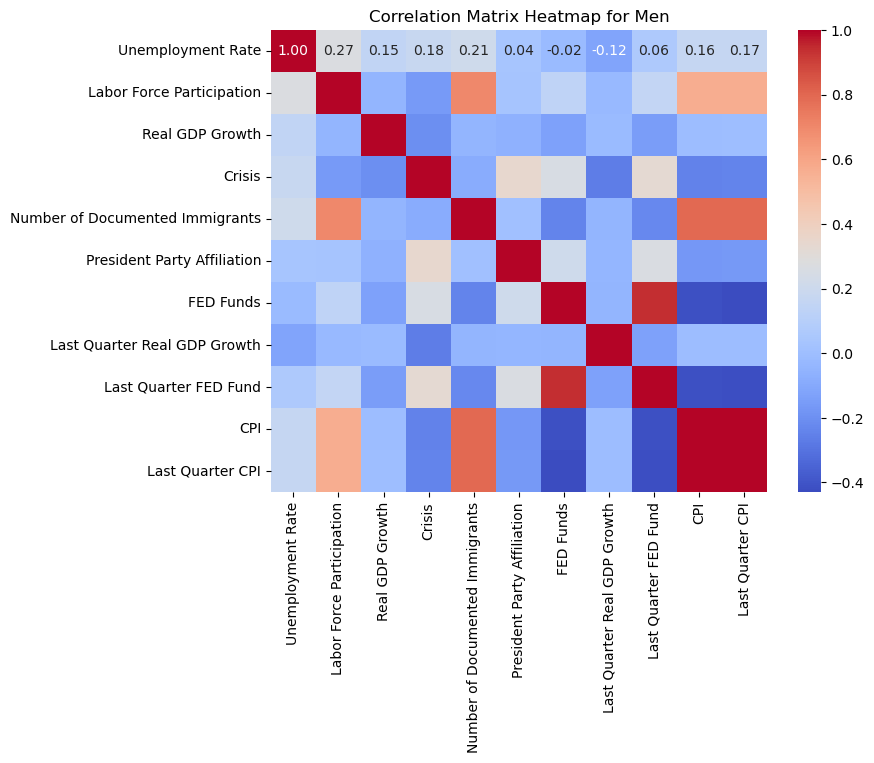

In [107]:
#correlation analysis of all variables of interest for men
subset_columns_men = ['Unemployment Rate', 'Labor Force Participation', 'Real GDP Growth','Crisis',"Number of Documented Immigrants",'President Party Affiliation', 'FED Funds','Last Quarter Real GDP Growth',
'Last Quarter FED Fund','CPI','Last Quarter CPI']

# Compute the correlation matrix for the subset of columns
correlation_matrix_men = df_men[subset_columns_men].corr()
# print("\nCorrelation matrix for men unemployment rate:")
# print(correlation_matrix_men)

#print correlation for men
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_men, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap for Men')
plt.show()

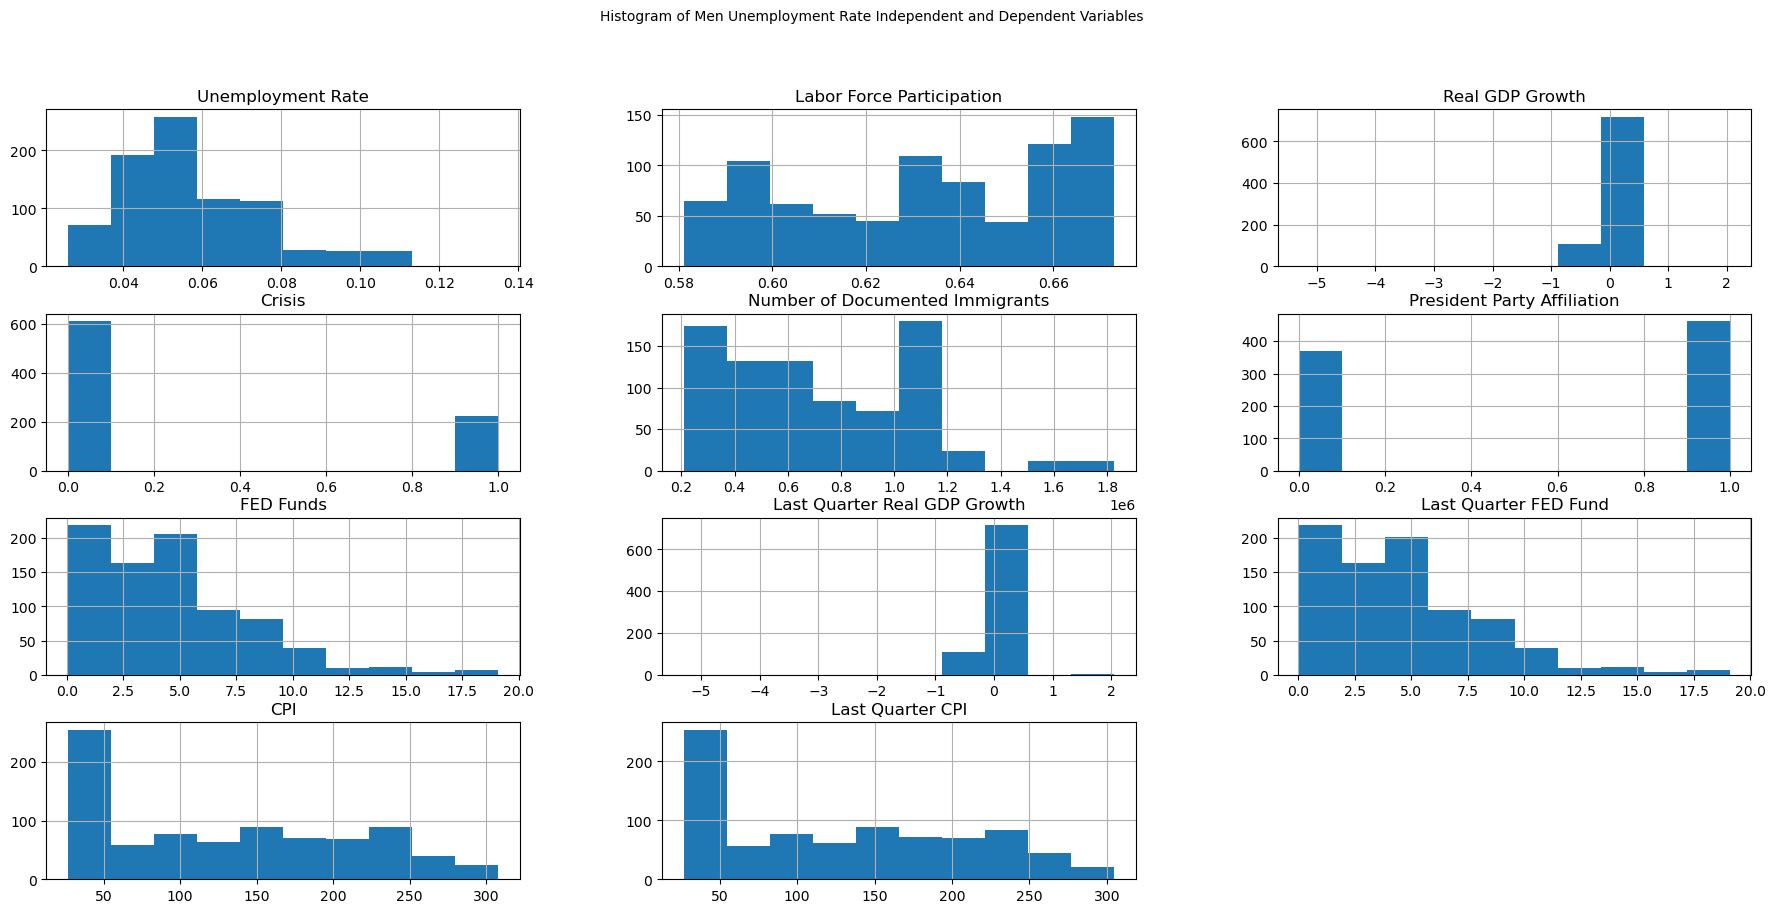

In [108]:
# Create histograms for the subset of columns to understand if any data need transformation
df_men[subset_columns_men].hist(figsize=(22, 10), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Men Unemployment Rate Independent and Dependent Variables', fontsize=10)
plt.xlabel('Value', fontsize=8)
plt.ylabel('Frequency', fontsize=8)

# Show the plot
plt.show()

#Many data are skewed and require transformation

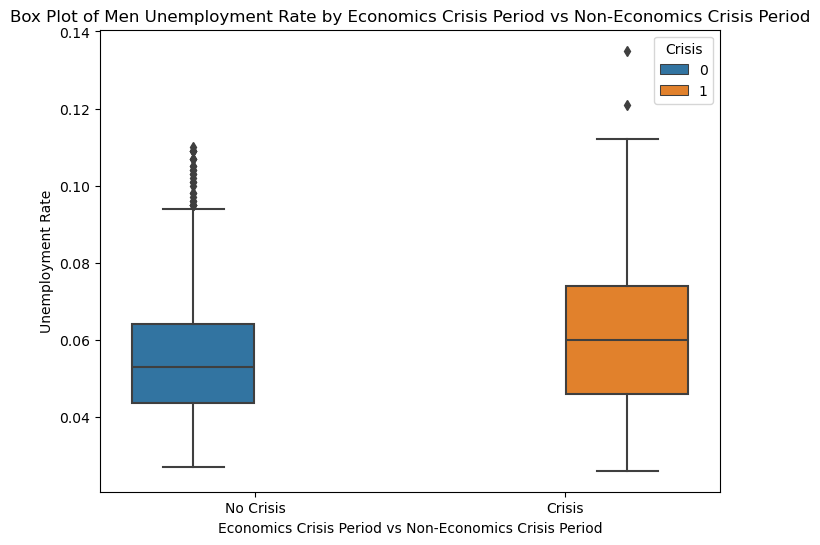

In [109]:
# Create a box plot with hue for men
plt.figure(figsize=(8, 6))
sns.boxplot(x='Crisis', y='Unemployment Rate', hue='Crisis', data=df_men)
plt.title('Box Plot of Men Unemployment Rate by Economics Crisis Period vs Non-Economics Crisis Period')
plt.xlabel('Economics Crisis Period vs Non-Economics Crisis Period')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['No Crisis', 'Crisis']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()
#Outlier exist and need to be removed

In [110]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) to identify outlier
Q1 = df_men['Unemployment Rate'].quantile(0.25)
Q3 = df_men['Unemployment Rate'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers 
outliers_iqr = df_men[(df_men['Unemployment Rate'] < lower_bound) | (df_men['Unemployment Rate'] > upper_bound)]

# print("\nOutliers using IQR method:")
# print(outliers_iqr)

In [111]:
#drop NA for men population for regression analysis
df_men=df_men.dropna()
nan_counts = df_men.isna().sum()
# print("Number of NaNs in each column:")
# print(nan_counts)

In [112]:
#Adding crisis interaction term 
df_men2=df_men.copy()
df_men2['Crisis_FED'] = df_men2['Crisis']*df_men2['Last Quarter FED Fund']
df_men2['Crisis_Labor'] = df_men2['Crisis']*df_men2['Labor Force Participation']
df_men2['Crisis_GDP'] = df_men2['Crisis']*df_men2['Last Quarter Real GDP Growth']
df_men2['Crisis_President'] = df_men2['Crisis']*df_men2['President Party Affiliation']
df_men2['Crisis_CPI'] = df_men2['Crisis']*df_men2['CPI']
df_men2['Crisis_LastQCPI'] = df_men2['Crisis']*df_men2['Last Quarter CPI']

In [113]:
#Drop outliers
df_men2 = df_men2[~((df_men2['Unemployment Rate'] < lower_bound) | (df_men2['Unemployment Rate'] > upper_bound))]
df_men2.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter FED Fund,Last Quarter CPI,Crisis,Last Quarter Real GDP Growth,Crisis_FED,Crisis_Labor,Crisis_GDP,Crisis_President,Crisis_CPI,Crisis_LastQCPI
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.80,26.86,1,0.182825,0.80,0.586,0.182825,1.0,26.78,26.86
5,1954-12-01,0.050,0.581,0.462691,208177.0,1.0,1.28,26.77,1.22,26.85,1,0.271374,1.22,0.581,0.271374,1.0,26.77,26.85
6,1955-01-01,0.048,0.586,0.439089,237790.0,1.0,1.39,26.77,1.07,26.81,0,0.348626,0.00,0.000,0.000000,0.0,0.00,0.00
7,1955-02-01,0.045,0.584,0.388965,237790.0,1.0,1.29,26.82,0.85,26.72,0,0.410838,0.00,0.000,0.000000,0.0,0.00,0.00
8,1955-03-01,0.045,0.585,0.329682,237790.0,1.0,1.35,26.79,0.83,26.78,0,0.452714,0.00,0.000,0.000000,0.0,0.00,0.00


In [114]:
# #Running multiple regression analysis without data transformation for men population
# X = df_men2[['Labor Force Participation','Number of Documented Immigrants','FED Funds', 'Last Quarter FED Fund','Crisis_President', 'Crisis_Labor','Last Quarter CPI']]
# X = sm.add_constant(X)
# model1_men = sm.OLS(df_men2['Unemployment Rate'], X).fit()
# # Get the residuals
# residual_men1 = model1_men.resid
# print("Multiple regression without log transformation:")
# print(model1_men.summary())
# #diagnostic for OLS Model 1
# # Q-Q plot for the model1_men residuals
# plt.figure(figsize=(8, 6))
# sm.qqplot(residual_men1, line='s')
# plt.title('Q-Q Plot of Residuals from Men Unemployment OLS Model')
# plt.show()
# # Shapiro-Wilk test for normality of residual
# shapiro_test = shapiro(residual_men1)
# print('Shapiro-Wilk Test:')
# print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

#Residuals are not normal

In [115]:
#Create a copy of df_men2 for log transformation
df_men3=df_men2.copy()
# df_men3.head()

In [116]:
df_men3.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter FED Fund,Last Quarter CPI,Crisis,Last Quarter Real GDP Growth,Crisis_FED,Crisis_Labor,Crisis_GDP,Crisis_President,Crisis_CPI,Crisis_LastQCPI
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.80,26.86,1,0.182825,0.80,0.586,0.182825,1.0,26.78,26.86
5,1954-12-01,0.050,0.581,0.462691,208177.0,1.0,1.28,26.77,1.22,26.85,1,0.271374,1.22,0.581,0.271374,1.0,26.77,26.85
6,1955-01-01,0.048,0.586,0.439089,237790.0,1.0,1.39,26.77,1.07,26.81,0,0.348626,0.00,0.000,0.000000,0.0,0.00,0.00
7,1955-02-01,0.045,0.584,0.388965,237790.0,1.0,1.29,26.82,0.85,26.72,0,0.410838,0.00,0.000,0.000000,0.0,0.00,0.00
8,1955-03-01,0.045,0.585,0.329682,237790.0,1.0,1.35,26.79,0.83,26.78,0,0.452714,0.00,0.000,0.000000,0.0,0.00,0.00


In [117]:
lagged_real_growth_min = df_men3["Last Quarter Real GDP Growth"].min()
lagged_real_growth_max = df_men3["Last Quarter Real GDP Growth"].max()
lagged_real_growth_median = df_men3["Last Quarter Real GDP Growth"].median()
lagged_real_growth_average = df_men3["Last Quarter Real GDP Growth"].mean()
lagged_real_growth_std = df_men3["Last Quarter Real GDP Growth"].std()
print(lagged_real_growth_min,lagged_real_growth_max,lagged_real_growth_median,lagged_real_growth_average,lagged_real_growth_std)

-5.300063909793072 2.052342118668983 0.011995892157051397 0.002313500021640799 0.29513408003974323


In [118]:
crisis_min = df_men3["Crisis"].min()
crisis_max = df_men3["Crisis"].max()
crisis_median = df_men3["Crisis"].median()
crisis_average = df_men3["Crisis"].mean()
crisis_std = df_men3["Crisis"].std()
print(crisis_min,crisis_max,crisis_median,crisis_average,crisis_std)

0 1 0.0 0.26 0.438908647671985


In [119]:
unemployment_min = df_men3["Unemployment Rate"].min()
unemployment_max = df_men3["Unemployment Rate"].max()
unemployment_median = df_men3["Unemployment Rate"].median()
unemployment_average = df_men3["Unemployment Rate"].mean()
unemployment_std = df_men3["Unemployment Rate"].std()
print(unemployment_min,unemployment_max,unemployment_median,unemployment_average,unemployment_std)

0.026000000000000002 0.106 0.053 0.056372500000000006 0.016756333493344402


In [120]:
#Log transform a subset of dependent variables
df_men3['Log_Labor Force Participation'] = np.log(df_men3['Labor Force Participation'])/10
df_men3['Log_Number of Documented Immigrants'] = np.log(df_men3['Number of Documented Immigrants'])
df_men3['Log_FED Funds'] = np.log(df_men3['FED Funds']/10)
df_men3['Log_Unemployment Rate'] = np.log(df_men3['Unemployment Rate'])
df_men3['Log_CPI'] = np.log(df_men3['CPI']/100)
df_men3['Log_Last Quarter FED Fund'] = np.log(df_men3['Last Quarter FED Fund']/10)
df_men3['Log_Last Quarter CPI'] = np.log(df_men3['Last Quarter CPI']/100)
df_men3.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,CPI,Last Quarter FED Fund,Last Quarter CPI,...,Crisis_President,Crisis_CPI,Crisis_LastQCPI,Log_Labor Force Participation,Log_Number of Documented Immigrants,Log_FED Funds,Log_Unemployment Rate,Log_CPI,Log_Last Quarter FED Fund,Log_Last Quarter CPI
4,1954-11-01,0.052,0.586,0.452714,208177.0,1.0,0.83,26.78,0.80,26.86,...,1.0,26.78,26.86,-0.053444,12.246144,-2.488915,-2.956512,-1.317515,-2.525729,-1.314532
5,1954-12-01,0.050,0.581,0.462691,208177.0,1.0,1.28,26.77,1.22,26.85,...,1.0,26.77,26.85,-0.054300,12.246144,-2.055725,-2.995732,-1.317888,-2.103734,-1.314904
6,1955-01-01,0.048,0.586,0.439089,237790.0,1.0,1.39,26.77,1.07,26.81,...,0.0,0.00,0.00,-0.053444,12.379143,-1.973281,-3.036554,-1.317888,-2.234926,-1.316395
7,1955-02-01,0.045,0.584,0.388965,237790.0,1.0,1.29,26.82,0.85,26.72,...,0.0,0.00,0.00,-0.053785,12.379143,-2.047943,-3.101093,-1.316022,-2.465104,-1.319758
8,1955-03-01,0.045,0.585,0.329682,237790.0,1.0,1.35,26.79,0.83,26.78,...,0.0,0.00,0.00,-0.053614,12.379143,-2.002481,-3.101093,-1.317142,-2.488915,-1.317515


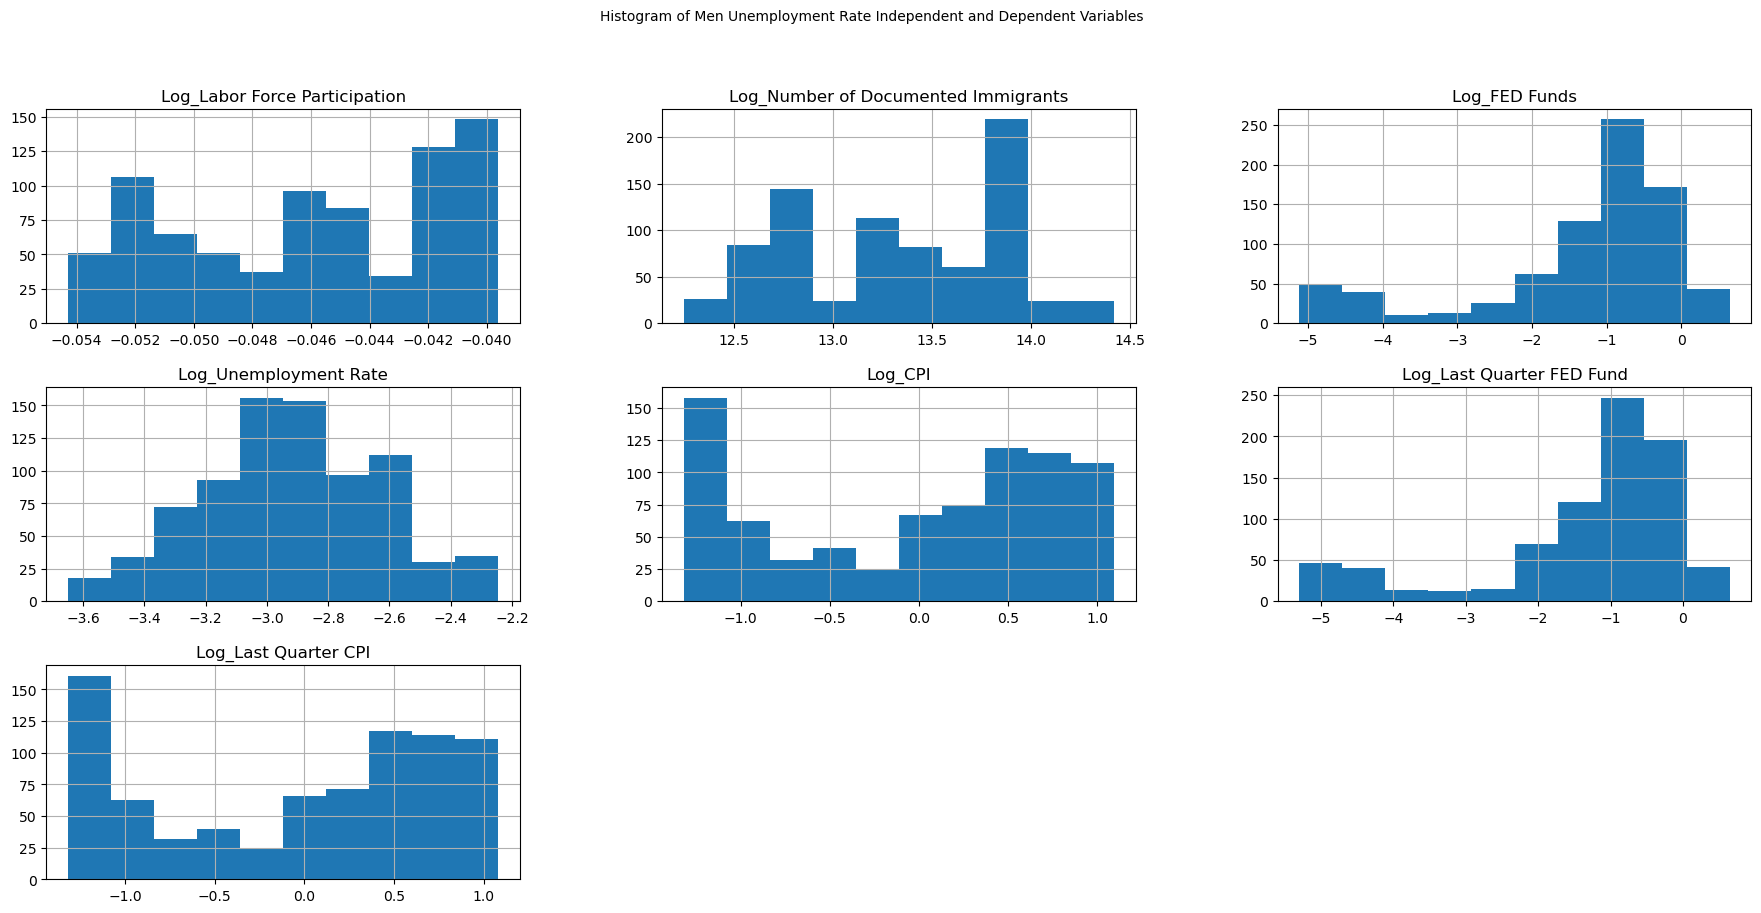

In [121]:
# Create histograms for the subset of columns to understand if any data need transformation
subset_columns_men3=['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_FED Funds','Log_Unemployment Rate','Log_CPI','Log_Last Quarter FED Fund','Log_Last Quarter CPI']
df_men3[subset_columns_men3].hist(figsize=(22, 10), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Men Unemployment Rate Independent and Dependent Variables', fontsize=10)
plt.xlabel('Value', fontsize=8)
plt.ylabel('Frequency', fontsize=8)

# Show the plot
plt.show()

In [122]:
#Adding crisis interaction term 
df_men3['Crisis_LogFED'] = df_men3['Crisis']*df_men3['Log_Last Quarter FED Fund']
df_men3['Crisis_LogImmig'] = df_men3['Crisis']*df_men3['Log_Number of Documented Immigrants']
df_men3['Crisis_LogCPI'] = df_men3['Crisis']*df_men3['Log_CPI']
df_men3['Crisis_LogLastQFED'] = df_men3['Crisis']*df_men3['Log_Last Quarter FED Fund'] 
df_men3['Crisis_LogLaborForce'] = df_men3['Crisis']*df_men3['Log_Labor Force Participation'] 
df_men3['Crisis_LogLastQCPI'] = df_men3['Crisis']*df_men3['Log_Last Quarter CPI']

In [123]:
df_men3.columns

Index(['Date', 'Unemployment Rate', 'Labor Force Participation',
       'Real GDP Growth', 'Number of Documented Immigrants',
       'President Party Affiliation', 'FED Funds', 'CPI',
       'Last Quarter FED Fund', 'Last Quarter CPI', 'Crisis',
       'Last Quarter Real GDP Growth', 'Crisis_FED', 'Crisis_Labor',
       'Crisis_GDP', 'Crisis_President', 'Crisis_CPI', 'Crisis_LastQCPI',
       'Log_Labor Force Participation', 'Log_Number of Documented Immigrants',
       'Log_FED Funds', 'Log_Unemployment Rate', 'Log_CPI',
       'Log_Last Quarter FED Fund', 'Log_Last Quarter CPI', 'Crisis_LogFED',
       'Crisis_LogImmig', 'Crisis_LogCPI', 'Crisis_LogLastQFED',
       'Crisis_LogLaborForce', 'Crisis_LogLastQCPI'],
      dtype='object')

In [124]:
df_men3["Prev Two Quarter Log FED Fund"] = df_men3['Log_Last Quarter FED Fund'].shift(4)
df_men3['Crisis_Log2LastQFED'] = df_men3['Crisis']*df_men3["Prev Two Quarter Log FED Fund"] 
#drop NA for men population for regression analysis
df_men3=df_men3.dropna()
df_men3.columns


Index(['Date', 'Unemployment Rate', 'Labor Force Participation',
       'Real GDP Growth', 'Number of Documented Immigrants',
       'President Party Affiliation', 'FED Funds', 'CPI',
       'Last Quarter FED Fund', 'Last Quarter CPI', 'Crisis',
       'Last Quarter Real GDP Growth', 'Crisis_FED', 'Crisis_Labor',
       'Crisis_GDP', 'Crisis_President', 'Crisis_CPI', 'Crisis_LastQCPI',
       'Log_Labor Force Participation', 'Log_Number of Documented Immigrants',
       'Log_FED Funds', 'Log_Unemployment Rate', 'Log_CPI',
       'Log_Last Quarter FED Fund', 'Log_Last Quarter CPI', 'Crisis_LogFED',
       'Crisis_LogImmig', 'Crisis_LogCPI', 'Crisis_LogLastQFED',
       'Crisis_LogLaborForce', 'Crisis_LogLastQCPI',
       'Prev Two Quarter Log FED Fund', 'Crisis_Log2LastQFED'],
      dtype='object')

In [125]:
#Running multiple regression analysis without data transformation for men population
X = df_men3[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 
'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']]
X = sm.add_constant(X)
model2_men = sm.OLS(df_men3['Log_Unemployment Rate'], X).fit()
# Get the residuals
residual_men2 = model2_men.resid
print("Multiple regression without log transformation:")
print(model2_men.summary())

# X = df_men3[['Log_Labor Force Participation','Log_Number of Documented Immigrants','Log_Last Quarter FED Fund',  'Crisis_LogImmig','Crisis_Log2LastQFED', 
# 'Crisis_LogLastQFED','Prev Two Quarter Log FED Fund','President Party Affiliation','Crisis_LogLaborForce']]

Multiple regression without log transformation:
                              OLS Regression Results                             
Dep. Variable:     Log_Unemployment Rate   R-squared:                       0.312
Model:                               OLS   Adj. R-squared:                  0.305
Method:                    Least Squares   F-statistic:                     39.69
Date:                   Thu, 13 Jun 2024   Prob (F-statistic):           2.09e-58
Time:                           19:21:32   Log-Likelihood:                -9.5870
No. Observations:                    796   AIC:                             39.17
Df Residuals:                        786   BIC:                             85.97
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [126]:
# Shapiro-Wilk test for normality of residual
shapiro_test = shapiro(residual_men2)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

Shapiro-Wilk Test:
Statistic: 0.994918942451477, p-value: 0.009448416531085968


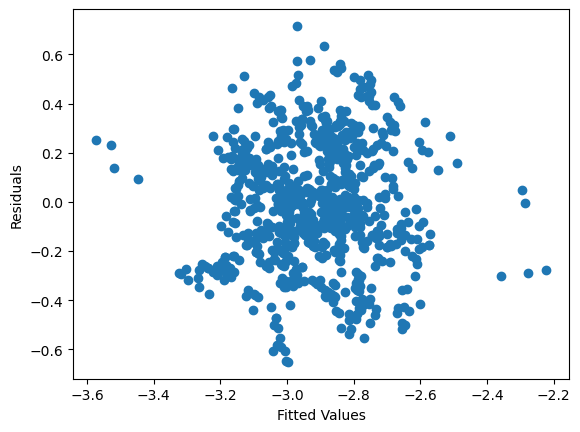

In [127]:
#Ensure that the residuals have constant variance (homoscedasticity).
# Residuals vs. Fitted values plot
plt.scatter(model2_men.fittedvalues, model2_men.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [128]:
#Ensure residuals are independent
from statsmodels.stats.stattools import durbin_watson

dw_test = durbin_watson(model2_men.resid)
print('Durbin-Watson Test:', dw_test)

#Confirm residuals are independent

Durbin-Watson Test: 0.10028410077396709


In [129]:
#merge all data for all women 
df_women= pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(unemployment_women, gdp_data, on = "YearMonth" ),laborforce_data, on = "YearMonth"),cpi_data, on = "YearMonth"),monthly_immig_data, on = "YearMonth", how = "left"),president_data, on = "YearMonth"),fedfund_data,on = "YearMonth")
df_women.head()

,DATE,LNS14000002,YearMonth,USALORSGPNOSTSAM,USALORSGPNOSTSAM1,Labor Force Participation,CPI,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS
0,1954-07-01,6.3,1954-07-01,97.80396,97.98277,58.4,26.86,208177.0,1.0,0.80
1,1954-08-01,6.2,1954-08-01,97.98277,98.24867,58.7,26.85,208177.0,1.0,1.22
2,1954-09-01,6.4,1954-09-01,98.24867,98.59119,59.2,26.81,208177.0,1.0,1.07
3,1954-10-01,5.8,1954-10-01,98.59119,98.99624,58.8,26.72,208177.0,1.0,0.85
4,1954-11-01,5.6,1954-11-01,98.99624,99.44441,58.6,26.78,208177.0,1.0,0.83


In [130]:
#normalize GDP via CPI, and other data
df_women["Real GDP"] = df_women['USALORSGPNOSTSAM'] / df_women['CPI']
df_women["Real GDP1"] = df_women['USALORSGPNOSTSAM1'] / df_women['CPI']
df_women["Real GDP Growth"] = (df_women["Real GDP1"] - df_women["Real GDP"])/df_women["Real GDP"]*100
df_women=df_women[['YearMonth', 'LNS14000002','Labor Force Participation','Real GDP Growth',"NUMBER OF DOCUMENTED IMMIGRANTS",'President Party Affiliation','FEDFUNDS']]
#scale labor force and umemployment data
df_women['Labor Force Participation'] = df_women['Labor Force Participation']/100
df_women['LNS14000002'] = df_women['LNS14000002']/100
#add one month lagged real GDP growth
df_women["Lagged Real GDP Growth"]= df_women['Real GDP Growth'].shift(1)
df_women.head()

,YearMonth,LNS14000002,Labor Force Participation,Real GDP Growth,NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS,Lagged Real GDP Growth
0,1954-07-01,0.063,0.584,0.182825,208177.0,1.0,0.80,NaN
1,1954-08-01,0.062,0.587,0.271374,208177.0,1.0,1.22,0.182825
2,1954-09-01,0.064,0.592,0.348626,208177.0,1.0,1.07,0.271374
3,1954-10-01,0.058,0.588,0.410838,208177.0,1.0,0.85,0.348626
4,1954-11-01,0.056,0.586,0.452714,208177.0,1.0,0.83,0.410838


In [131]:
#change project 1 men dataset name
df_women.rename(columns={'YearMonth': 'Date', 'LNS14000002': 'Unemployment Rate', 'Labor Force Participation':'Labor Force Participation',
                    'Real GDP Growth':'Real GDP Growth', "Lagged Real GDP Growth":"Lagged Real GDP Growth","NUMBER OF DOCUMENTED IMMIGRANTS": "Number of Documented Immigrants",'President Party Affiliation':'President Party Affiliation','FEDFUNDS':'FED Funds'}, inplace=True)
df_women.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,Lagged Real GDP Growth
0,1954-07-01,0.063,0.584,0.182825,208177.0,1.0,0.80,NaN
1,1954-08-01,0.062,0.587,0.271374,208177.0,1.0,1.22,0.182825
2,1954-09-01,0.064,0.592,0.348626,208177.0,1.0,1.07,0.271374
3,1954-10-01,0.058,0.588,0.410838,208177.0,1.0,0.85,0.348626
4,1954-11-01,0.056,0.586,0.452714,208177.0,1.0,0.83,0.410838


In [132]:
#Create a US economic crisis column with dummy variable =1 if crisis and 0 otherwise
df_women['Year'] = df_women['Date'].dt.year

# Define the years considered as crisis years
crisis_years = [1948, 1949, 1953,1954,1957,1958,1960,1961,1969,1970,1973,1974,1975,1980,1981,1982,1990,1991,2001,2008,2009,2020]

# Create a new column 'Crisis' and set values based on the year
df_women['Crisis'] = df_women['Year'].apply(lambda x: 1 if x in crisis_years else 0)

# Display the DataFrame
df_women.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,Lagged Real GDP Growth,Year,Crisis
0,1954-07-01,0.063,0.584,0.182825,208177.0,1.0,0.80,NaN,1954,1
1,1954-08-01,0.062,0.587,0.271374,208177.0,1.0,1.22,0.182825,1954,1
2,1954-09-01,0.064,0.592,0.348626,208177.0,1.0,1.07,0.271374,1954,1
3,1954-10-01,0.058,0.588,0.410838,208177.0,1.0,0.85,0.348626,1954,1
4,1954-11-01,0.056,0.586,0.452714,208177.0,1.0,0.83,0.410838,1954,1


In [155]:
lagged_real_growth_min = df_women["Lagged Real GDP Growth"].min()
lagged_real_growth_max = df_women["Lagged Real GDP Growth"].max()
lagged_real_growth_median = df_women["Lagged Real GDP Growth"].median()
lagged_real_growth_average = df_women["Lagged Real GDP Growth"].mean()
lagged_real_growth_std = df_women["Lagged Real GDP Growth"].std()
print(lagged_real_growth_min,lagged_real_growth_max,lagged_real_growth_median,lagged_real_growth_average,lagged_real_growth_std)

-5.300063909793072 2.052342118668983 0.0127111420087633 0.002692250491572228 0.2919824069920091


In [156]:
crisis_min = df_women["Crisis"].min()
crisis_max = df_women["Crisis"].max()
crisis_median = df_women["Crisis"].median()
crisis_average = df_women["Crisis"].mean()
crisis_std = df_women["Crisis"].std()
print(crisis_min,crisis_max,crisis_median,crisis_average,crisis_std)

0 1 0.0 0.269183922046285 0.4438060898632672


In [157]:
unemployment_min = df_women["Unemployment Rate"].min()
unemployment_max = df_women["Unemployment Rate"].max()
unemployment_median = df_women["Unemployment Rate"].median()
unemployment_average = df_women["Unemployment Rate"].mean()
unemployment_std = df_women["Unemployment Rate"].std()
print(unemployment_min,unemployment_max,unemployment_median,unemployment_average,unemployment_std)

0.034 0.162 0.059000000000000004 0.06123142509135201 0.015415071387880999


In [133]:
#correlation analysis of all variables of interest for women
subset_columns_women = ['Unemployment Rate', 'Labor Force Participation', 'Real GDP Growth','Lagged Real GDP Growth','Crisis','President Party Affiliation', 'FED Funds']

# Compute the correlation matrix for the subset of columns
correlation_matrix_women = df_women[subset_columns_women].corr()
print("\nCorrelation matrix for unemployment rate and economics indicator:")
print(correlation_matrix_women)


Correlation matrix for unemployment rate and economics indicator:
                             Unemployment Rate  Labor Force Participation  \
Unemployment Rate                     1.000000                  -0.056900   
Labor Force Participation            -0.056900                   1.000000   
Real GDP Growth                       0.178060                  -0.049154   
Lagged Real GDP Growth                0.037076                  -0.032941   
Crisis                                0.225898                  -0.161489   
President Party Affiliation           0.043588                   0.030440   
FED Funds                             0.189037                   0.134269   

                             Real GDP Growth  Lagged Real GDP Growth  \
Unemployment Rate                   0.178060                0.037076   
Labor Force Participation          -0.049154               -0.032941   
Real GDP Growth                     1.000000                0.619575   
Lagged Real GDP Growth      

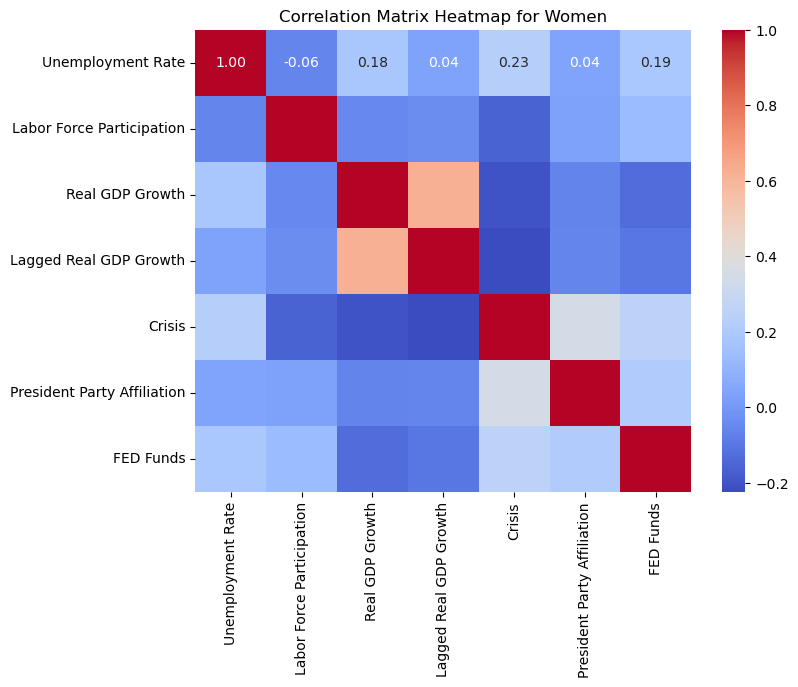

In [154]:
#print correlation 
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_women, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap for Women')
plt.show()

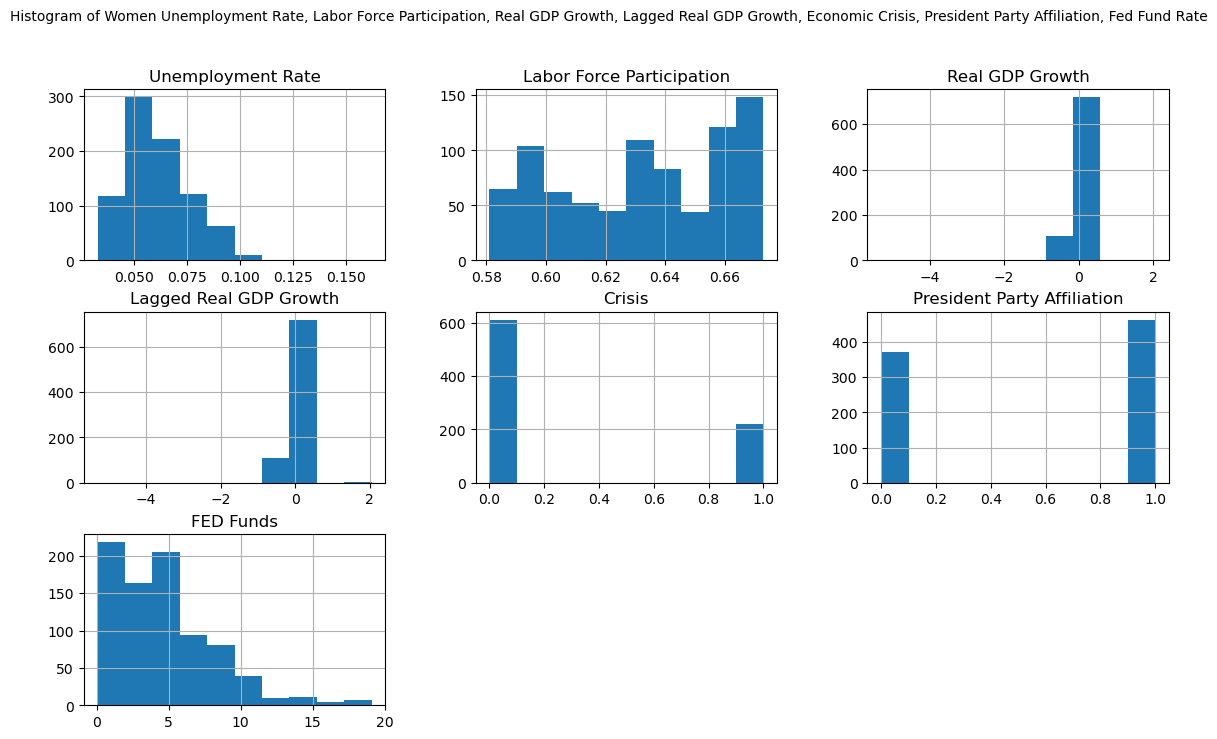

In [135]:
# Create histograms for the subset of columns to understand if any data need transformation
df_women[subset_columns_women].hist(figsize=(14, 8), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Women Unemployment Rate, Labor Force Participation, Real GDP Growth, Lagged Real GDP Growth, Economic Crisis, President Party Affiliation, Fed Fund Rate', fontsize=10)
plt.xlabel('Value', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Show the plot
plt.show()

#Many data are skewed and require transformation

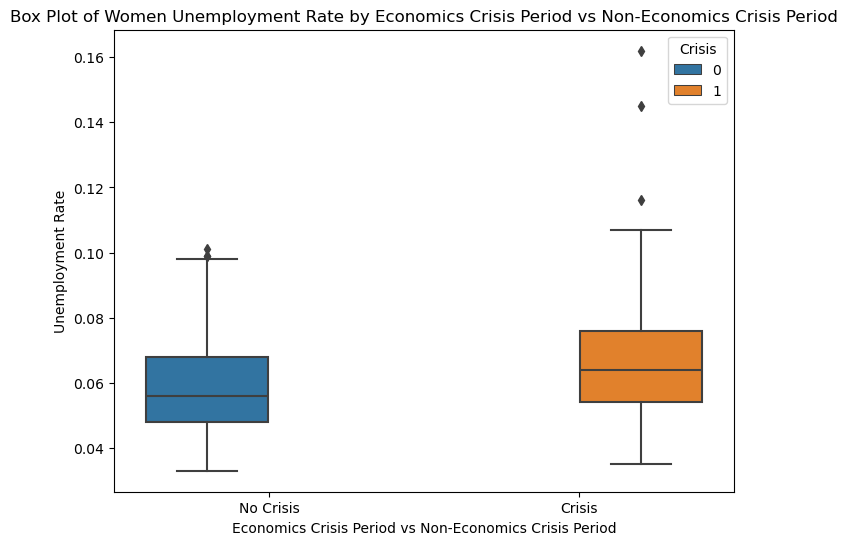

In [136]:
# Create a box plot with hue for women
plt.figure(figsize=(8, 6))
sns.boxplot(x='Crisis', y='Unemployment Rate', hue='Crisis', data=df_women)
plt.title('Box Plot of Women Unemployment Rate by Economics Crisis Period vs Non-Economics Crisis Period')
plt.xlabel('Economics Crisis Period vs Non-Economics Crisis Period')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['No Crisis', 'Crisis']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()

In [137]:

# X = np.log(df_men[['Labor Force Participation', 'Real GDP Growth','Lagged Real GDP Growth','Crisis']])
# model2_men = sm.OLS(df_men['Y'], X).fit()
# print("\nMultiple regression with log transformation for X1:")
# print(model2_men.summary())


In [138]:
#drop NA for women population for regression analysis
df_women=df_women.dropna()
nan_counts = df_women.isna().sum()

print("Number of NaNs in each column:")
print(nan_counts)

Number of NaNs in each column:
Date                               0
Unemployment Rate                  0
Labor Force Participation          0
Real GDP Growth                    0
Number of Documented Immigrants    0
President Party Affiliation        0
FED Funds                          0
Lagged Real GDP Growth             0
Year                               0
Crisis                             0
dtype: int64


In [139]:
#Running multiple regression analysis without data transformation for women population
X = df_women[['Labor Force Participation','Lagged Real GDP Growth','Crisis','President Party Affiliation', 'FED Funds']]
X = sm.add_constant(X)
model1_women = sm.OLS(df_women['Unemployment Rate'], X).fit()
residual_women = model1_women.resid
print("Multiple regression without log transformation:")
print(model1_women.summary())

Multiple regression without log transformation:
                            OLS Regression Results                            
Dep. Variable:      Unemployment Rate   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     15.53
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           1.29e-14
Time:                        19:21:36   Log-Likelihood:                 2298.5
No. Observations:                 821   AIC:                            -4585.
Df Residuals:                     815   BIC:                            -4557.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [153]:
df_women.head()



,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Number of Documented Immigrants,President Party Affiliation,FED Funds,Lagged Real GDP Growth,Year,Crisis
1,1954-08-01,0.062,0.587,0.271374,208177.0,1.0,1.22,0.182825,1954,1
2,1954-09-01,0.064,0.592,0.348626,208177.0,1.0,1.07,0.271374,1954,1
3,1954-10-01,0.058,0.588,0.410838,208177.0,1.0,0.85,0.348626,1954,1
4,1954-11-01,0.056,0.586,0.452714,208177.0,1.0,0.83,0.410838,1954,1
5,1954-12-01,0.052,0.581,0.462691,208177.0,1.0,1.28,0.452714,1954,1


<Figure size 800x600 with 0 Axes>

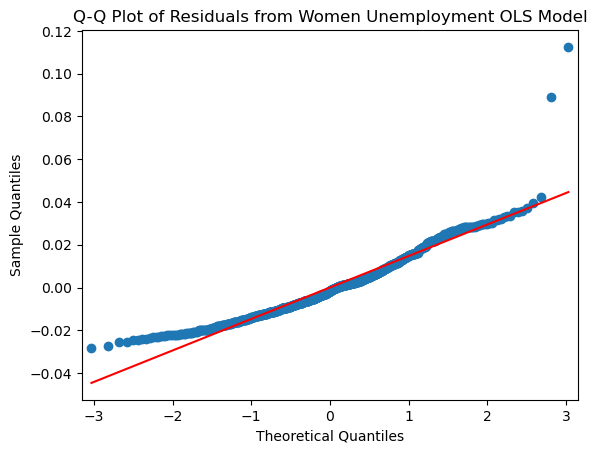

In [140]:
# Q-Q plot for the model1_men residuals
plt.figure(figsize=(8, 6))
sm.qqplot(residual_women, line='s')
plt.title('Q-Q Plot of Residuals from Women Unemployment OLS Model')
plt.show()

In [141]:
# Shapiro-Wilk test for normality
shapiro_test = shapiro(residual_women)
print('Shapiro-Wilk Test:')
print(f'Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')


Shapiro-Wilk Test:
Statistic: 0.9356175065040588, p-value: 2.4234646596711224e-18


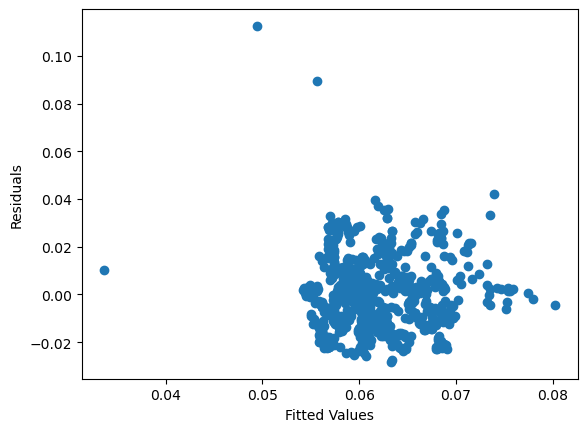

Breusch-Pagan Test: (61.157272993173095, 7.006198127816437e-12, 13.119340547162532, 2.639011424625098e-12)


In [142]:
#Ensure that the residuals have constant variance (homoscedasticity).
# Residuals vs. Fitted values plot
plt.scatter(model1_women.fittedvalues, model1_women.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Breusch-Pagan Test
bp_test = het_breuschpagan(model1_women.resid, model1_women.model.exog)
print('Breusch-Pagan Test:', bp_test)

In [143]:
#Ensure residuals are independent
from statsmodels.stats.stattools import durbin_watson

dw_test = durbin_watson(model1_women.resid)
print('Durbin-Watson Test:', dw_test)

Durbin-Watson Test: 0.11719132432086804


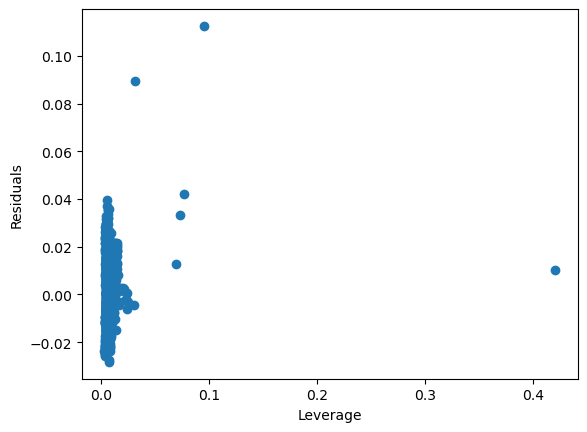

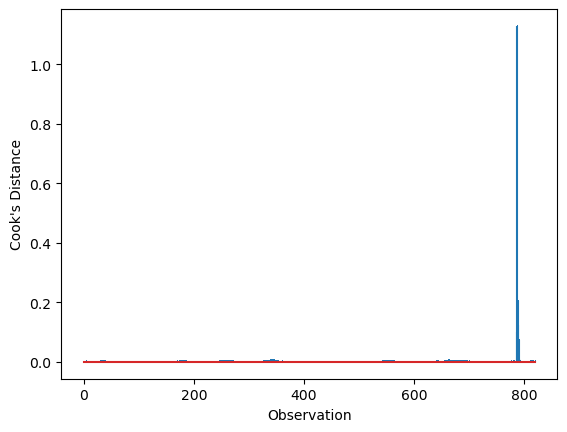

In [144]:
#Check for outliers and their influences
influence = model1_women.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# Plot leverage vs. residuals
plt.scatter(leverage, model1_women.resid)
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.show()

# Plot Cook's distance
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.show()

## Total Population Summary

In [145]:
#merge all data for all population
df_all= pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(unemployment_df, gdp_data, on = "YearMonth" ),laborforce_data, on = "YearMonth"),cpi_data, on = "YearMonth"),monthly_edu_data, on = "YearMonth"),monthly_immig_data, on = "YearMonth"),president_data, on = "YearMonth"),fedfund_data,on = "YearMonth")
df_all.head()

,YearMonth,Unemployment Rate,USALORSGPNOSTSAM,USALORSGPNOSTSAM1,Labor Force Participation,CPI,% Highest degree is middle school,% Highest degree is High School,% Highest degree is College (4 + years),NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS
0,1957-01-01,4.2,101.11500,101.09880,59.5,27.67,0.31,0.26,0.07,326867,1.0,2.84
1,1959-01-01,6.0,100.00650,100.36230,59.3,29.01,0.29,0.27,0.08,260686,1.0,2.48
2,1960-01-01,5.2,101.02030,101.03100,59.1,29.37,0.31,0.25,0.08,265398,1.0,3.99
3,1962-01-01,5.8,100.09590,100.18910,58.8,30.04,0.28,0.28,0.09,283763,0.0,2.15
4,1964-01-01,5.6,99.66704,99.72102,58.6,30.94,0.27,0.30,0.09,292248,0.0,3.48


In [146]:
#normalize GDP via CPI
df_all["Real GDP"] = df_all['USALORSGPNOSTSAM'] / df_all['CPI']
df_all["Real GDP1"] = df_all['USALORSGPNOSTSAM1'] / df_all['CPI']
df_all["Real GDP Growth"] = (df_all["Real GDP1"] - df_all["Real GDP"])/df_all["Real GDP"]*100
df_all=df_all[['YearMonth', 'Unemployment Rate','Labor Force Participation','Real GDP Growth', '% Highest degree is middle school', '% Highest degree is High School', '% Highest degree is  College (4 + years)' ,'NUMBER OF DOCUMENTED IMMIGRANTS','President Party Affiliation','FEDFUNDS']]
#scale labor force and umemployment data
df_all['Labor Force Participation'] = df_all['Labor Force Participation']/100
df_all['Unemployment Rate'] = df_all['Unemployment Rate']/100
#add one month lagged real GDP growth
df_all["Lagged Real GDP Growth"]= df_all['Real GDP Growth'].shift(1)
df_all.head()

,YearMonth,Unemployment Rate,Labor Force Participation,Real GDP Growth,% Highest degree is middle school,% Highest degree is High School,% Highest degree is College (4 + years),NUMBER OF DOCUMENTED IMMIGRANTS,President Party Affiliation,FEDFUNDS,Lagged Real GDP Growth
0,1957-01-01,0.042,0.595,-0.016021,0.31,0.26,0.07,326867,1.0,2.84,NaN
1,1959-01-01,0.060,0.593,0.355777,0.29,0.27,0.08,260686,1.0,2.48,-0.016021
2,1960-01-01,0.052,0.591,0.010592,0.31,0.25,0.08,265398,1.0,3.99,0.355777
3,1962-01-01,0.058,0.588,0.093111,0.28,0.28,0.09,283763,0.0,2.15,0.010592
4,1964-01-01,0.056,0.586,0.054160,0.27,0.30,0.09,292248,0.0,3.48,0.093111


In [147]:
#change project 1 dataset name
df_all.rename(columns={'YearMonth': 'Date', 'Unemployment Rate': 'Unemployment Rate', 'Labor Force Participation':'Labor Force Participation',
                    'Real GDP Growth':'Real GDP Growth', '% Highest degree is middle school': "Middle School Degree%",'% Highest degree is High School': "High School Degree%",
                    '% Highest degree is  College (4 + years)': "College Degree%", "Lagged Real GDP Growth":"Lagged Real GDP Growth",'President Party Affiliation':'President Party Affiliation','NUMBER OF DOCUMENTED IMMIGRANTS':'Number of Documented Immigrants','FEDFUNDS':'FED Funds'}, inplace=True)
df_all.head()

,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Middle School Degree%,High School Degree%,College Degree%,Number of Documented Immigrants,President Party Affiliation,FED Funds,Lagged Real GDP Growth
0,1957-01-01,0.042,0.595,-0.016021,0.31,0.26,0.07,326867,1.0,2.84,NaN
1,1959-01-01,0.060,0.593,0.355777,0.29,0.27,0.08,260686,1.0,2.48,-0.016021
2,1960-01-01,0.052,0.591,0.010592,0.31,0.25,0.08,265398,1.0,3.99,0.355777
3,1962-01-01,0.058,0.588,0.093111,0.28,0.28,0.09,283763,0.0,2.15,0.010592
4,1964-01-01,0.056,0.586,0.054160,0.27,0.30,0.09,292248,0.0,3.48,0.093111


In [148]:
#Create a US economic crisis column with dummy variable =1 if crisis and 0 otherwise
df_all['Year'] = df_all['Date'].dt.year

# Define the years considered as crisis years
crisis_years = [1948, 1949, 1953,1954,1957,1958,1960,1961,1969,1970,1973,1974,1975,1980,1981,1982,1990,1991,2001,2008,2009,2020]

# Create a new column 'Crisis' and set values based on the year
df_all['Crisis'] = df_all['Year'].apply(lambda x: 1 if x in crisis_years else 0)

# Display the DataFrame
df_all.head()


,Date,Unemployment Rate,Labor Force Participation,Real GDP Growth,Middle School Degree%,High School Degree%,College Degree%,Number of Documented Immigrants,President Party Affiliation,FED Funds,Lagged Real GDP Growth,Year,Crisis
0,1957-01-01,0.042,0.595,-0.016021,0.31,0.26,0.07,326867,1.0,2.84,NaN,1957,1
1,1959-01-01,0.060,0.593,0.355777,0.29,0.27,0.08,260686,1.0,2.48,-0.016021,1959,0
2,1960-01-01,0.052,0.591,0.010592,0.31,0.25,0.08,265398,1.0,3.99,0.355777,1960,1
3,1962-01-01,0.058,0.588,0.093111,0.28,0.28,0.09,283763,0.0,2.15,0.010592,1962,0
4,1964-01-01,0.056,0.586,0.054160,0.27,0.30,0.09,292248,0.0,3.48,0.093111,1964,0


In [149]:
#correlation analysis of all variables of interest
subset_columns = ['Unemployment Rate', 'Labor Force Participation', 'Real GDP Growth','Lagged Real GDP Growth','Middle School Degree%',
                  'High School Degree%', 'College Degree%','Crisis','Number of Documented Immigrants','President Party Affiliation','FED Funds']

# Compute the correlation matrix for the subset of columns
correlation_matrix = df_all[subset_columns].corr()
print("\nCorrelation matrix for unemployment rate and economics indicator:")
print(correlation_matrix)


Correlation matrix for unemployment rate and economics indicator:
                                 Unemployment Rate  Labor Force Participation  \
Unemployment Rate                         1.000000                   0.158204   
Labor Force Participation                 0.158204                   1.000000   
Real GDP Growth                           0.174783                   0.005312   
Lagged Real GDP Growth                   -0.127455                   0.051680   
Middle School Degree%                    -0.165312                  -0.768259   
High School Degree%                       0.317097                   0.387720   
College Degree%                           0.070429                   0.525052   
Crisis                                    0.163471                  -0.131513   
Number of Documented Immigrants           0.060812                   0.648308   
President Party Affiliation               0.052381                   0.045967   
FED Funds                                 

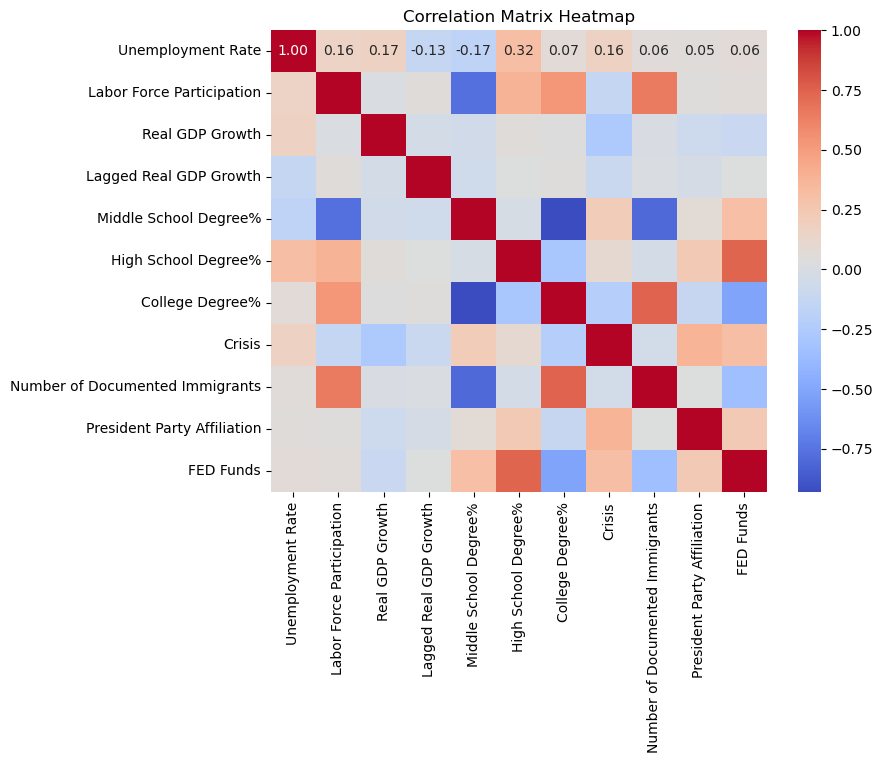

In [150]:
#print correlation 
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

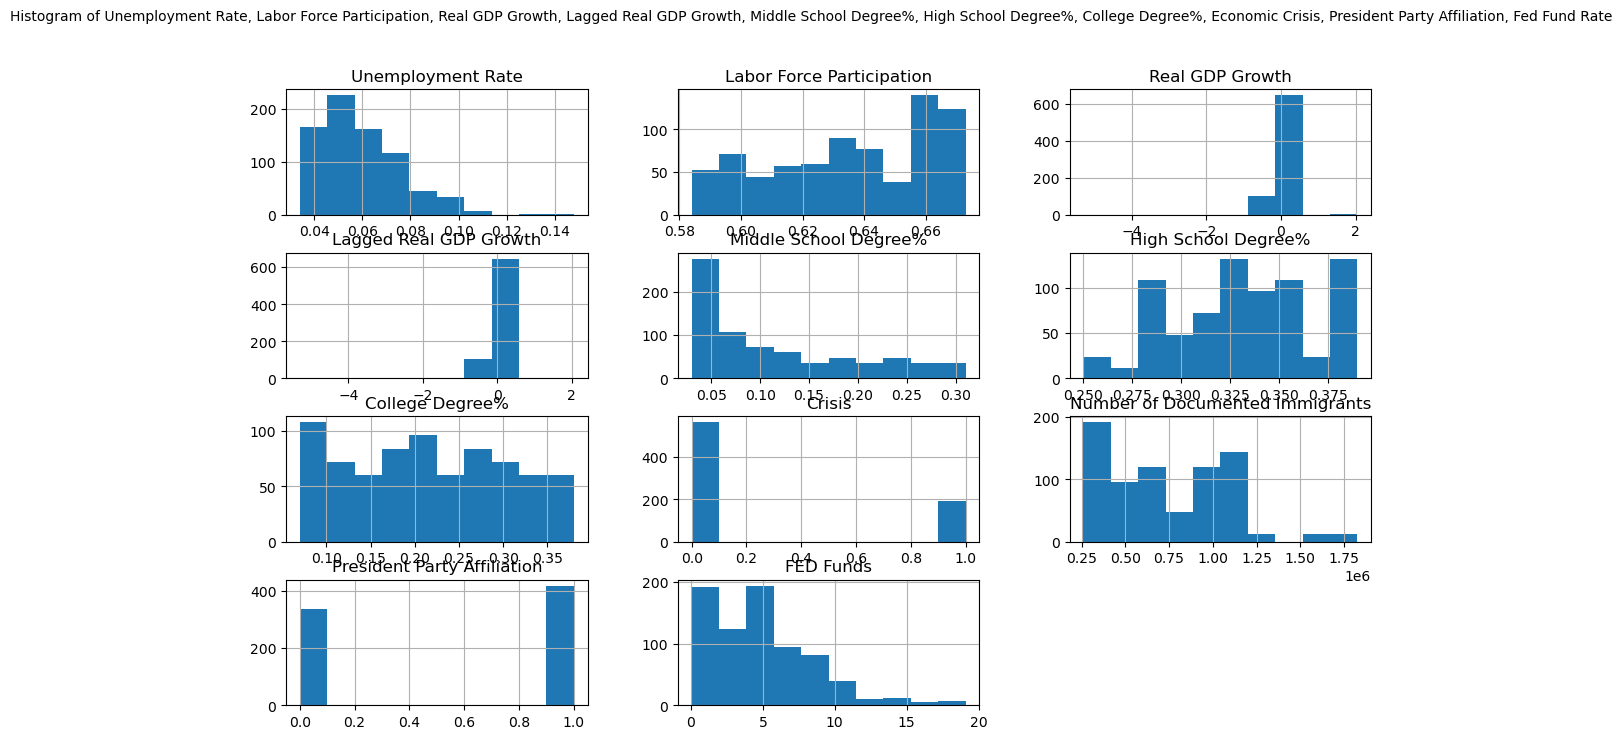

In [151]:
# Create histograms for the subset of columns to understand if any data need transformation
df_all[subset_columns].hist(figsize=(14, 8), bins=10)  # Adjust figsize and bins as needed

# Add titles and labels
plt.suptitle('Histogram of Unemployment Rate, Labor Force Participation, Real GDP Growth, Lagged Real GDP Growth, Middle School Degree%, High School Degree%, College Degree%, Economic Crisis, President Party Affiliation, Fed Fund Rate', fontsize=10)
plt.xlabel('Value', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Show the plot
plt.show()

#Many data are skewed and require transformation

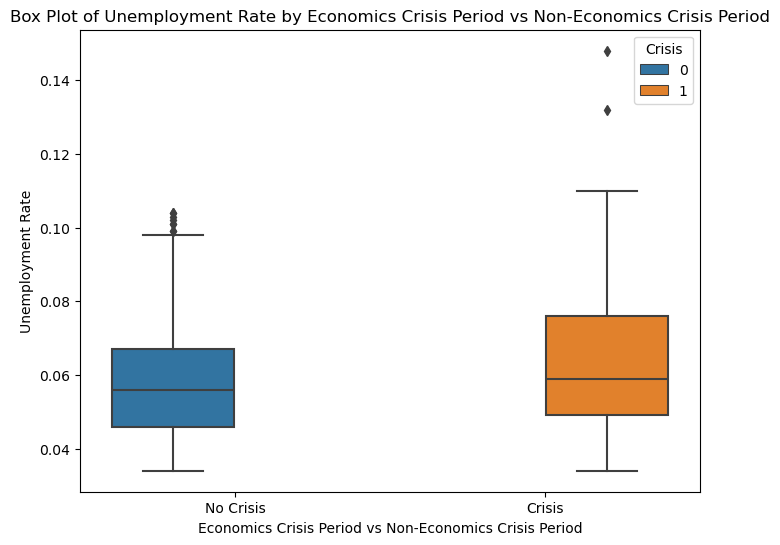

In [152]:
# Create a box plot with hue
plt.figure(figsize=(8, 6))
sns.boxplot(x='Crisis', y='Unemployment Rate', hue='Crisis', data=df_all)
plt.title('Box Plot of Unemployment Rate by Economics Crisis Period vs Non-Economics Crisis Period')
plt.xlabel('Economics Crisis Period vs Non-Economics Crisis Period')
plt.ylabel('Unemployment Rate')
# Modify the x-axis labels
new_labels = ['No Crisis', 'Crisis']
plt.xticks(ticks=[0, 1], labels=new_labels)
plt.show()